In [53]:
import pandas as pd
import ast
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
from tqdm.auto import tqdm
from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Set random seed
seed = 0

In [54]:
# Read cleaned data from csv
df = pd.read_csv('input/movie_data_tmbd_cleaned.csv', sep='|')

In [55]:
# Print info about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17112 entries, 0 to 17111
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 17112 non-null  int64  
 1   budget                17112 non-null  int64  
 2   genres                17072 non-null  object 
 3   original_language     17112 non-null  object 
 4   overview              17112 non-null  object 
 5   popularity            17112 non-null  float64
 6   production_companies  15769 non-null  object 
 7   production_countries  16637 non-null  object 
 8   revenue               17112 non-null  int64  
 9   runtime               17112 non-null  float64
 10  spoken_languages      16971 non-null  object 
 11  status                17112 non-null  object 
 12  tagline               17112 non-null  object 
 13  video                 17112 non-null  int64  
 14  vote_average          17112 non-null  float64
 15  vote_count         

# Score prediction

In [56]:
df['video'].value_counts()

video
0    17036
1       76
Name: count, dtype: int64

In [57]:
# Get list of all unique names in df[`cast`]
df['cast'] = df['cast'].replace(np.nan, '')
unique_cast = df['cast'].str.split(',').explode()
unique_cast.value_counts()
# Take only actors that appeared in more than 10 movies
top_cast = unique_cast.value_counts()[unique_cast.value_counts() > 10]

df['cast'] = df['cast'].apply(lambda x: [i for i in x.split(',') if i in top_cast.index]).apply(lambda x: ','.join(x))
df['production_companies'] = df['production_companies'].replace(np.nan, '')
unique_production_companies = df['production_companies'].str.split(',').explode()
unique_production_companies.value_counts()

top_companies = unique_production_companies.value_counts()[unique_production_companies.value_counts() > 10]
df['production_companies'] = df['production_companies'].apply(lambda x: [i for i in x.split(',') if i in top_companies.index]).apply(lambda x: ','.join(x))
df['directors'] = df['directors'].replace(np.nan, '')
unique_directors = df['directors'].str.split(',').explode()
unique_directors.value_counts()

top_directors = unique_directors.value_counts()[unique_directors.value_counts() > 10]
df['directors'] = df['directors'].apply(lambda x: [i for i in x.split(',') if i in top_directors.index]).apply(lambda x: ','.join(x))
df['production_countries'] = df['production_countries'].replace(np.nan, '')
df['spoken_languages'] = df['spoken_languages'].replace(np.nan, '')
df['genres'] = df['genres'].replace(np.nan, '')


In [58]:
X = df.drop(columns=['vote_average', 'category'])
X = df.drop(columns=['video', 'adult', 'release_day'])
Y = df['category']


In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

# Encode target variable (Y) using LabelEncoder
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)


print("Training set size: ", len(X_train))
print("Test set size: ", len(X_test))

Training set size:  13689
Test set size:  3423


# Feature encoding

In [60]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17112 entries, 0 to 17111
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                17112 non-null  int64  
 1   genres                17112 non-null  object 
 2   original_language     17112 non-null  object 
 3   overview              17112 non-null  object 
 4   popularity            17112 non-null  float64
 5   production_companies  17112 non-null  object 
 6   production_countries  17112 non-null  object 
 7   revenue               17112 non-null  int64  
 8   runtime               17112 non-null  float64
 9   spoken_languages      17112 non-null  object 
 10  status                17112 non-null  object 
 11  tagline               17112 non-null  object 
 12  vote_average          17112 non-null  float64
 13  vote_count            17112 non-null  float64
 14  cast                  17112 non-null  object 
 15  directors          

In [61]:
print(X.head())

     budget                                  genres original_language  \
0         0                                   Drama                en   
1   7000000                                   Drama                en   
2    600000  TV Movie,Science Fiction,Action,Horror                en   
3         0                                  Comedy                en   
4  15000000                                  Comedy                en   

                                            overview  popularity  \
0  A group of 5 people find themselves trapped in...      11.082   
1  In the early 70s, Cathy Rush becomes the head ...       8.506   
2  When a fracking mishap accidentally rips apart...       6.943   
3  Plucky and innocent Laci Cox is hired to teach...       7.311   
4  After one short date, a brilliant crossword co...      13.802   

                                production_companies  \
0                                                      
1                                       

In [62]:


from sklearn.pipeline import FunctionTransformer
from sklearn.preprocessing import MultiLabelBinarizer


numerical_features = ['budget', 'revenue', 'popularity', 'runtime', 'vote_count', 'release_year', 'release_month']
categorical_features = ['original_language', 'status']
boolean_features = ['adult', 'video']
text_features = ['overview', 'tagline']
list_based_features = ['genres', 'production_companies', 'production_countries', 'cast', 'directors']

# 1. Numerical transformer: Impute missing values and standardize
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Categorical transformer: Impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 3. Boolean transformer: Ensure 0/1 values
boolean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# 4. Text transformer: Use TF-IDF for text columns
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=100))  # Adjust max_features as needed
])

# 5. List-based transformer: Convert list of items into count vectors (like multi-hot encoding)
def list_to_str(column):
    return column.apply(lambda x: ','.join(x) if isinstance(x, list) else '')

def extract_first_item(column):
    return column.apply(lambda x: x.split(',')[0] if isinstance(x, str) and ',' in x else x)

def string_to_list(column):
    return column.apply(lambda x: x.split(',') if isinstance(x, str) else [])


# 5. MultiLabelBinarizer for list-based features
list_transformer_mlb = Pipeline(steps=[
    ('to_list', FunctionTransformer(string_to_list, validate=False)),  # Convert string to list
    ('mlb', MultiLabelBinarizer())  # MultiLabelBinarizer to encode list columns as binary features
])

# 6. Extract first item for genres and directors, and treat them as categorical
first_item_transformer = Pipeline(steps=[
    ('extract_first', FunctionTransformer(extract_first_item, validate=False)),  # Extract first element
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # OneHotEncode the extracted value
])

# Combine all transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        # ('bool', boolean_transformer, boolean_features),
        ('overview', text_transformer, 'overview'),
        ('tagline', text_transformer, 'tagline'),
        ('genres', text_transformer, 'genres'),
        ('production_companies', text_transformer, 'production_companies'),
        ('production_countries', text_transformer, 'production_countries'),
        ('cast', text_transformer, 'cast'),
        ('directors', text_transformer, 'directors')
    ]
)


# Opaque models

## SVM

In [63]:
# get nans in every column
print(X_train.isnull().sum())


budget                  0
genres                  0
original_language       0
overview                0
popularity              0
production_companies    0
production_countries    0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
tagline                 0
vote_average            0
vote_count              0
cast                    0
directors               0
release_year            0
release_month           0
category                0
dtype: int64


In [64]:
clf = svm.SVC(gamma='auto')

# Define your pipeline with preprocessor
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svc', clf)
])

svm_pipeline.fit(X_train, Y_train_encoded)
Y_pred = svm_pipeline.predict(X_test)

# Convert predicted labels back to original categories
Y_pred_labels = label_encoder.inverse_transform(Y_pred)

accuracy = accuracy_score(Y_test_encoded, Y_pred)
print("Accuracy: ", accuracy)

# Optionally: Check predicted labels
print("Predicted labels:", Y_pred_labels)

Accuracy:  0.4843704352906807
Predicted labels: ['good' 'good' 'great' ... 'great' 'good' 'bad']


In [65]:
# Use randm search to find best hyperparameters
param_dist = {
    'svc__C': uniform(0.1, 10),
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__degree': randint(1, 10),
    'svc__gamma': ['scale', 'auto']
}

random_search = RandomizedSearchCV(svm_pipeline, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=seed, verbose=2, n_jobs=-1)
random_search.fit(X_train, Y_train_encoded)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END svc__C=5.588135039273247, svc__degree=6, svc__gamma=scale, svc__kernel=sigmoid; total time=  35.3s
[CV] END svc__C=5.588135039273247, svc__degree=6, svc__gamma=scale, svc__kernel=sigmoid; total time=  35.1s
[CV] END svc__C=5.588135039273247, svc__degree=6, svc__gamma=scale, svc__kernel=sigmoid; total time=  35.7s
[CV] END svc__C=5.588135039273247, svc__degree=6, svc__gamma=scale, svc__kernel=sigmoid; total time=  36.9s
[CV] END svc__C=5.588135039273247, svc__degree=6, svc__gamma=scale, svc__kernel=sigmoid; total time=  38.3s
[CV] END svc__C=0.6671297731744318, svc__degree=2, svc__gamma=scale, svc__kernel=sigmoid; total time=  41.0s
[CV] END svc__C=8.679456176227568, svc__degree=8, svc__gamma=auto, svc__kernel=sigmoid; total time=  56.5s
[CV] END svc__C=8.679456176227568, svc__degree=8, svc__gamma=auto, svc__kernel=sigmoid; total time=  56.8s
[CV] END svc__C=8.679456176227568, svc__degree=8, svc__gamma=auto, svc__kern

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['budget',
                                                                                'revenue',
                                                                                'popularity',
                                                                                'runtime',
                                                                                'vote_count',
                                                                                'release_year',
                                                                                'release_month']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_fr...
                                             ('svc', SVC(gamma='auto'))]),
                   n_jobs=-1,
                   param_distributions={'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x13eff6a90>,
                                        'svc__degree': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x13eff4390>,
                                        'svc__gamma': ['scale', 'auto'],
                                        'svc__kernel': ['linear', 'poly', 'rbf',
                                                        'sigmoid']},
                   random_state=0, scoring='accuracy', verbose=2)

In [66]:
# Print best hyperparameters
print("Best hyperparameters: ", random_search.best_params_)

Best hyperparameters:  {'svc__C': 6.558941130666561, 'svc__degree': 5, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}


In [67]:
# Predict using best model
Y_pred = random_search.predict(X_test)
Y_pred_labels = label_encoder.inverse_transform(Y_pred)


In [68]:
accuracy = accuracy_score(Y_test_encoded, Y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.5150452819164476


In [69]:
print(Y_test.value_counts())

category
good        870
great       864
mediocre    856
bad         833
Name: count, dtype: int64


In [70]:
print(Y_train.value_counts())

category
bad         3445
mediocre    3422
great       3414
good        3408
Name: count, dtype: int64


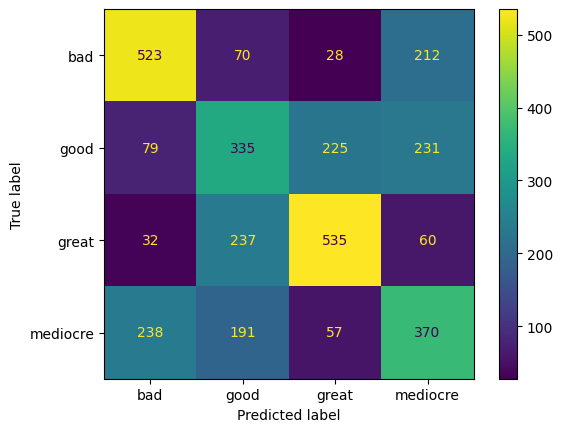

In [71]:
# Print confusion matrix for the model
cm = confusion_matrix(Y_test_encoded, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()